In [1]:
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math
import numpy as np

In [2]:
random.seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# evaluates a polynomial sum_i(a[i] * x^i)
def eval_polynomial(x, *a):
        y=0
        for i, ai in enumerate(a):
            y += ai * pow(x, i)
        return y

# creates a polynomial with fixed parameters
def create_polynomial(*a):
    print(f'Creating polynomial with params {a}')
    return lambda x : eval_polynomial(x, *a)

# y = a
def create_constant(a):
    return create_polynomial(a)

# y = ax + b
def create_linear(a, b):
    return create_polynomial(b, a)

# y = ax^2 + bx + c
def create_quadratic(a, b, c):
    return create_polynomial(c, b, a)

# y = ax^3 + bx^2 + c*x + d
def create_cubic(a, b, c, d):
    return create_polynomial(d, c, b, a)

# y = ax^4 + bx^3 + c*x^2 + d*x + e
def create_quartic(a, b, c, d, e):
    return create_polynomial(e, d, c, b, a)

def random_x(n, min=-10, max=10):
    return [random.uniform(min, max) for i in range(n)]

In [4]:
class Quadratic(nn.Module):
    """ Custom layer that maps [x] -> [x^2, x]"""
    def __init__(self, scale):
        super().__init__()
        self.scale = scale
    
    def forward(self, x):
        # Divide by some linear factor to improve stability (prevents Inf overflow).
        return torch.cat((torch.div(torch.square(x), self.scale), x), 1) 

In [5]:
class SimpleLinearModel(nn.Module):
    """ Linear NN with one input, one hidden layer, and one output."""
    def __init__(self, n):
        super(SimpleLinearModel, self).__init__()
        self.layer_stack = nn.Sequential(
#             nn.Linear(1, 1),
            nn.Linear(1, n),
            nn.ReLU(),
            nn.Linear(n, 1),       
        )

    def forward(self, x):
        yh = self.layer_stack(x)
        return yh
    
class SimpleQuadraticModel(nn.Module):
    """ Quadratic (parabolic) NN with one input, one hidden layer, and one output."""
    def __init__(self, n, scale):
        super(SimpleQuadraticModel, self).__init__()
        self.layer_stack = nn.Sequential(
#             Quadratic(),    # [x] -> [x, x^2]
#             nn.Linear(2, 1),   # hi = [w0*x + w1*x^2] + wb
            Quadratic(scale),    # [x] -> [x, x^2]
            nn.Linear(2, n),   # hi = [w0*x + w1*x^2] + wb
            Quadratic(scale),    # [h] -> [h] + [h^2]
            nn.Linear(2*n, 1), # y = [w0*h + w1*h^2] + wb 
        )
#         with torch.no_grad():
#             self.layer_stack[1].weight[0][0] = 0.
#             self.layer_stack[3].weight[0][0] = 0.

    def forward(self, x):
        yh = self.layer_stack(x)
        return yh
    
class SimpleFunctionDataset(torch.utils.data.Dataset):
    def __init__(self, x, fn):
        super(SimpleFunctionDataset, self).__init__()
        # stick each item in its own list so we have n items of size 1 instead of 1 item of size n.
        self.y = torch.tensor(list(map(lambda yi: [fn(yi)], x)), dtype=torch.float).to(device)
        self.x = torch.tensor(list(map(lambda xi: [xi], x)), dtype=torch.float).to(device)

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        sample = {"x": self.x[idx], "y": self.y[idx]}
        return sample
    
def paramsAsList(model):
    params = []
    for p in model.parameters():
        params.append(p.tolist())
    return params

class LQTrainer:
    def __init__(self, model_l, model_q, lr=0.01):
        self.nnl = model_l
        self.nnq = model_q
        self.optimizer_l = torch.optim.SGD(self.nnl.parameters(), lr = lr) 
        self.optimizer_q = torch.optim.SGD(self.nnq.parameters(), lr = lr) 
        self.all_losses_l = [] 
        self.all_losses_q = [] 
        self.plot_every = 50 
        print(f'lr = {lr}')

    def clearLossHistory(self):
        self.all_losses_l = [] 
        self.all_losses_q = [] 
    
    def printParams(self):
        print(f'L: {paramsAsList(self.nnl)}')
        print(f'Q: {paramsAsList(self.nnq)}')
    
    def plotError(self):
        plt.plot(self.all_losses_l, color="Blue", label="Linear")
        plt.plot(self.all_losses_q, color="Orange", label="Quadratic")
        plt.ylabel('Log Loss')
        plt.legend()        
    
    def train(self, epochs, batch_size, train_data, logCallback=None):
        current_loss_l = 0 
        current_loss_q = 0 

        for epoch in range(epochs): 
            # remove current gradients for next iteration   
            # input training example and return the prediction
            batch_indexes = torch.randint(len(train_data.x), (batch_size,))
#             print(batch_indexes)
            batch_x = train_data.x[batch_indexes]
            batch_y = train_data.y[batch_indexes]
            
            yl = self.nnl.forward(batch_x)
            yq = self.nnq.forward(batch_x)

            # calculate MSE loss   
            loss_l = nn.functional.mse_loss(yl, batch_y)
            loss_q = nn.functional.mse_loss(yq, batch_y)
#             print(f'yq={yq.tolist()} y={batch_y.tolist()} mse={loss_q.tolist()}')

            if loss_l.isnan():
                print(f'Linear Loss is NaN. Halting at epoch {epoch}.')
                break

            if loss_l.isinf():
                print(f'Linear Loss is Inf. Halting at epoch {epoch}.')
                break

            if loss_q.isnan():
                print(f'Quadratic Loss is NaN. Halting at epoch {epoch}.')
                break

            if loss_q.isinf():
                print(f'Quadratic Loss is Inf. Halting at epoch {epoch}.')
                break

            # backpropogate through the loss gradiants   
            self.optimizer_l.zero_grad() 
            self.optimizer_q.zero_grad() 

            loss_l.backward()
            loss_q.backward()

            # update model weights   
            self.optimizer_l.step()
            self.optimizer_q.step()

            # append to loss   
            current_loss_l += loss_l  
            current_loss_q += loss_q  

            if epoch > 0 and epoch % self.plot_every == (self.plot_every-1):
                self.all_losses_l.append(math.log(0.00000000001+(current_loss_l / self.plot_every).item()))       
                self.all_losses_q.append(math.log(0.00000000001+(current_loss_q / self.plot_every).item()))       
                print(f'Epoch: {epoch} L Loss: {(current_loss_l / self.plot_every)} Q Loss: {(current_loss_q / self.plot_every)}')
                if logCallback:
                    logCallback()
                current_loss_l = 0 
                current_loss_q = 0 

In [6]:
class Experiment:
    def __init__(self, fn, qscale, lr, lsize, qsize):
        self.fn = fn
        self.qscale = qscale
        self.lr = lr
        self.lsize = lsize
        self.qsize = qsize
        # create stuff
        self.train_data = SimpleFunctionDataset(x=random_x(1000, -5, 5), fn=fn)

        self.nnl = SimpleLinearModel(lsize).to(device)
        self.nnq = SimpleQuadraticModel(qsize, qscale).to(device)
        self.trainer = LQTrainer(self.nnl, self.nnq, lr=lr)
    
    def plotFn(self):
        plt.rcParams['figure.figsize'] = [6.0, 4.0]
        x = np.arange(-15, 15, 0.1)
        y = np.array([self.fn(xi) for xi in x])
        plt.plot(x, y, label="Fn", linewidth=1.5, color="Gray")
        plt.show()
        
    def plotError(self):
        plt.rcParams['figure.figsize'] = [6.0, 4.0]
        self.trainer.plotError()
        plt.show()
        
    def plotModels(self, w=6.0, h=4.0):
        plt.rcParams['figure.figsize'] = [w, h]

        x = np.arange(-5, 5, 0.1)
        y = np.array([self.fn(xi) for xi in x])
        x_ten = torch.tensor(list(map(lambda xi: [xi], x)), dtype=torch.float).to(device)
        y_lin = self.nnl.forward(x_ten).tolist()
        y_qua = self.nnq.forward(x_ten).tolist()

        plt.plot(x, y, label="Fn", linewidth=6, color="Orange")
        plt.plot(x, y_lin, label="Linear", linewidth=3, color="Green")
        plt.plot(x, y_qua, label="Quadratic", linewidth=1, color="Black")

        plt.legend()
        plt.show()

    def train(self, epochs, batch_size):
        self.trainer.train(epochs, batch_size, self.train_data, self.plotModels)

In [7]:
exps = [None] * 5

exps[0] = Experiment(
    create_constant(random.uniform(-10,10)), 
    qscale = 16, 
    lr = 2e-4, 
    lsize = 4, 
    qsize = 2)

exps[1] = Experiment(
    fn = create_linear(random.uniform(-10,10), random.uniform(-10,10)),
    qscale = 16,
    lr = 2e-4,
    lsize = 4,
    qsize = 2)

exps[2] = Experiment(
    fn = create_quadratic(random.uniform(-10,10), random.uniform(-10,10), random.uniform(-10,10)),
    qscale = 16,
    lr = 2e-4,
    lsize = 4,
    qsize = 2)

exps[3] = Experiment(
    fn = create_cubic(random.uniform(-10,10), random.uniform(-10,10), random.uniform(-10,10), random.uniform(-10,10)),
    qscale = 16,
    lr = 1e-4,
    lsize = 8,
    qsize = 4)

exps[4] = Experiment(
    fn = create_quartic(random.uniform(-1,1), random.uniform(-1,1), random.uniform(-1,1), random.uniform(-1,1), random.uniform(-1,1)),
    qscale = 16,
    lr = 1e-4,
    lsize = 16,
    qsize = 8)

Creating polynomial with params (6.888437030500963,)
lr = 0.0002
Creating polynomial with params (5.572354682922198, 6.3677522037679815)
lr = 0.0002
Creating polynomial with params (3.161898128859166, -6.423718110277267, -6.310500682052278)
lr = 0.0002
Creating polynomial with params (5.649950348684056, -6.909379141220402, 3.8962870809653065, -1.1954613238405276)
lr = 0.0001
Creating polynomial with params (0.21823798696618768, 0.7039796679632835, -0.986628514220175, -0.5467673255456844, 0.9185500403172846)
lr = 0.0001


In [8]:
epochs = 10000
batch_size = 25
plot_every = 500

def runExperiment(exp):
    exp.trainer.plot_every = plot_every
    
    exp.plotModels()
    exp.train(epochs, batch_size)

    exp.plotError()
    exp.plotModels(18.0, 12.0)

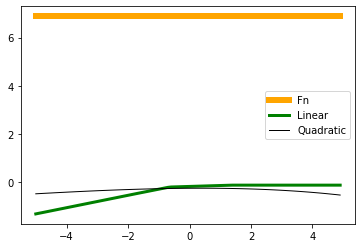

Epoch: 499 L Loss: 39.69032669067383 Q Loss: 35.16835403442383


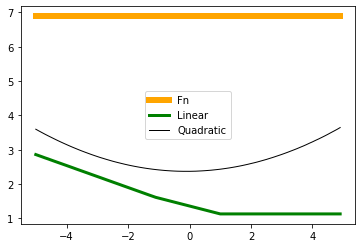

Epoch: 999 L Loss: 19.242965698242188 Q Loss: 6.073671817779541


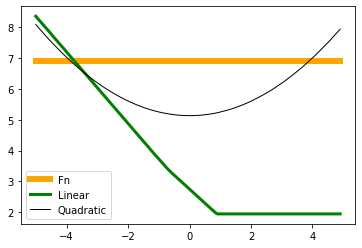

Epoch: 1499 L Loss: 12.339208602905273 Q Loss: 0.9438176155090332


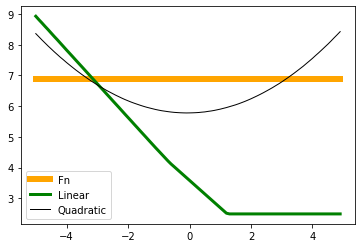

Epoch: 1999 L Loss: 9.180073738098145 Q Loss: 0.5790602564811707


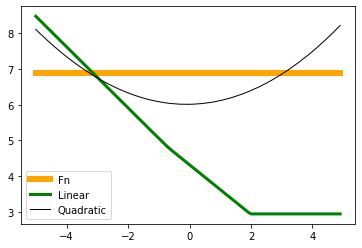

Epoch: 2499 L Loss: 5.624878406524658 Q Loss: 0.38502928614616394


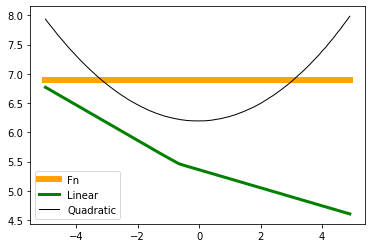

Epoch: 2999 L Loss: 0.8264597058296204 Q Loss: 0.2539839744567871


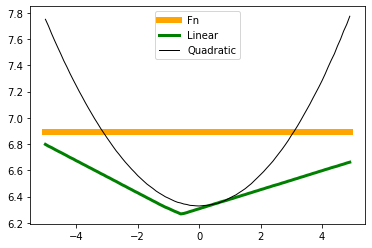

Epoch: 3499 L Loss: 0.07278598845005035 Q Loss: 0.16718347370624542


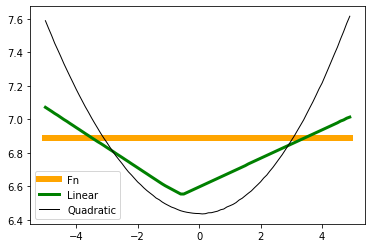

Epoch: 3999 L Loss: 0.024257082492113113 Q Loss: 0.10908931493759155


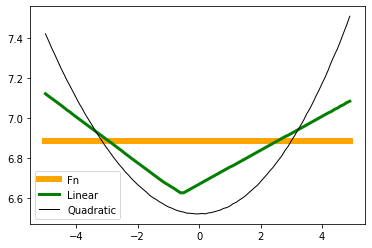

Epoch: 4499 L Loss: 0.020071761682629585 Q Loss: 0.07199062407016754


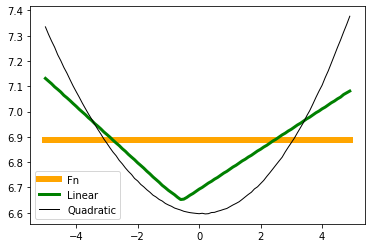

Epoch: 4999 L Loss: 0.01801191456615925 Q Loss: 0.04614880308508873


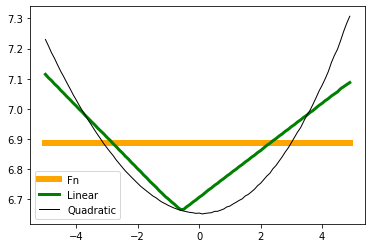

Epoch: 5499 L Loss: 0.016341714188456535 Q Loss: 0.030091051012277603


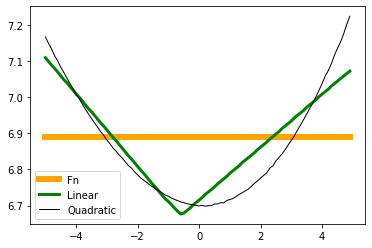

Epoch: 5999 L Loss: 0.015081413090229034 Q Loss: 0.01970101147890091


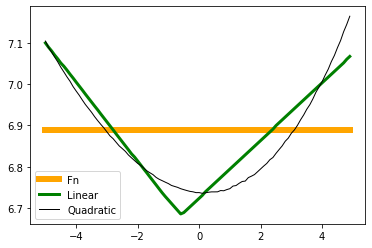

Epoch: 6499 L Loss: 0.01364761684089899 Q Loss: 0.012529677711427212


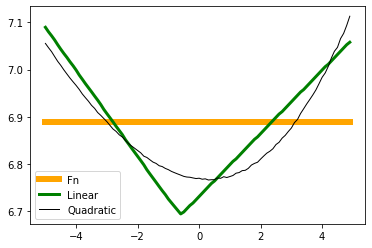

Epoch: 6999 L Loss: 0.012329465709626675 Q Loss: 0.007995937019586563


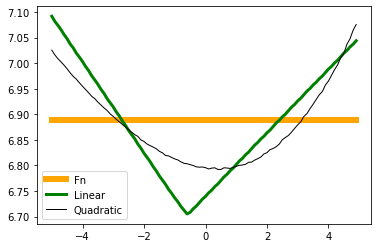

Epoch: 7499 L Loss: 0.011400031857192516 Q Loss: 0.0051669287495315075


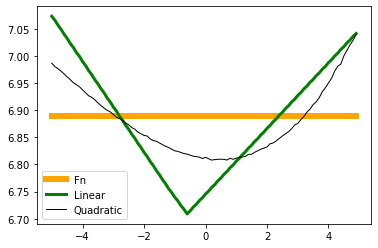

Epoch: 7999 L Loss: 0.010475645773112774 Q Loss: 0.003356756642460823


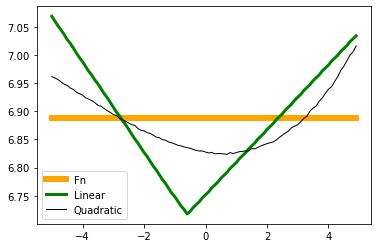

Epoch: 8499 L Loss: 0.009410412050783634 Q Loss: 0.0021654635202139616


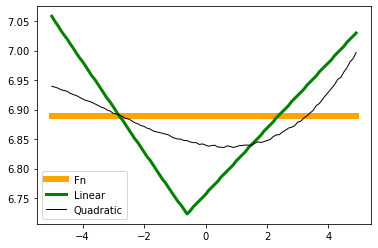

Epoch: 8999 L Loss: 0.008725578896701336 Q Loss: 0.0014369734562933445


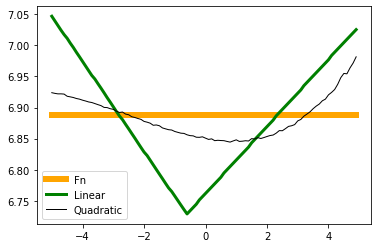

Epoch: 9499 L Loss: 0.008022340014576912 Q Loss: 0.000962662510573864


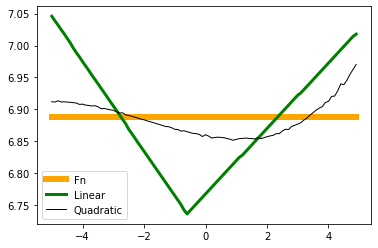

Epoch: 9999 L Loss: 0.007387916091829538 Q Loss: 0.0006588708492927253


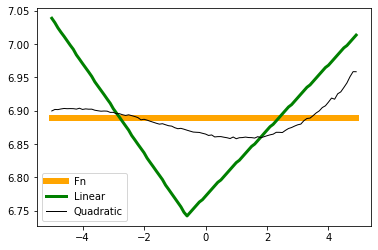

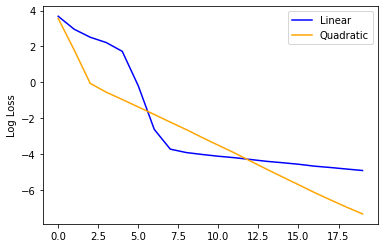

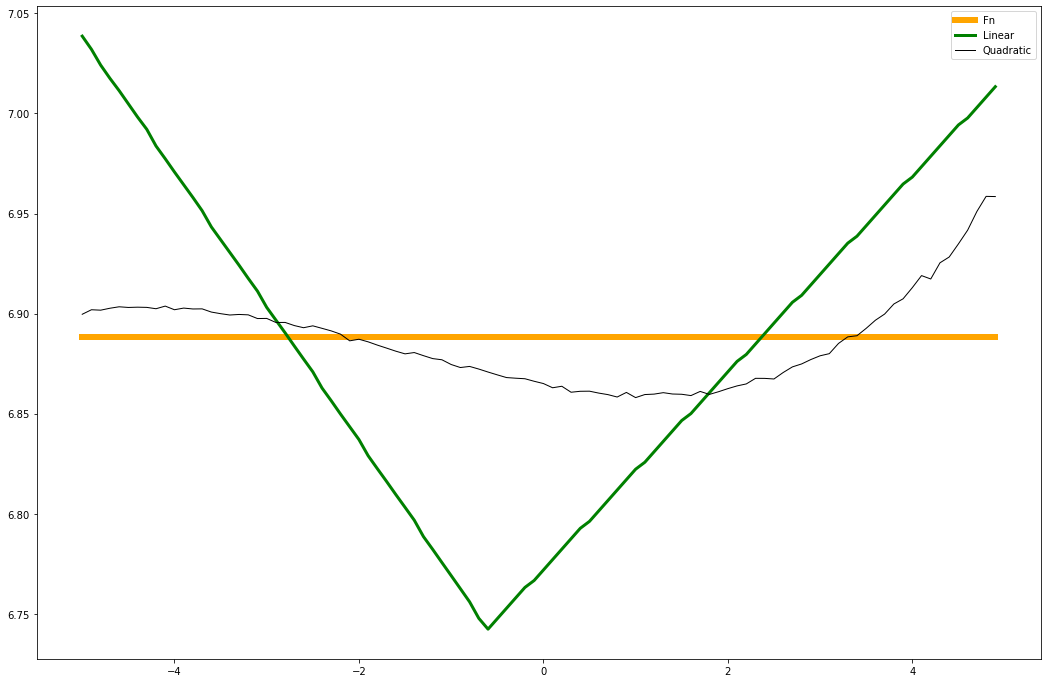

In [9]:
runExperiment(exps[0])

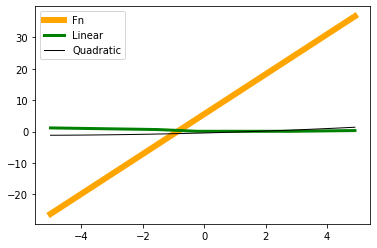

Epoch: 499 L Loss: 113.27703857421875 Q Loss: 46.898014068603516


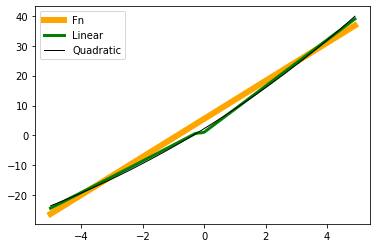

Epoch: 999 L Loss: 3.4542236328125 Q Loss: 3.095740556716919


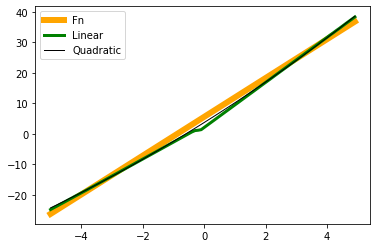

Epoch: 1499 L Loss: 2.1398983001708984 Q Loss: 1.036751389503479


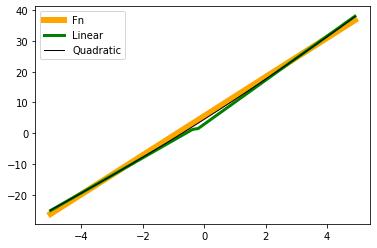

Epoch: 1999 L Loss: 1.270762324333191 Q Loss: 0.34225818514823914


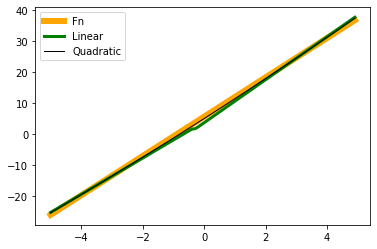

Epoch: 2499 L Loss: 0.7187639474868774 Q Loss: 0.11493214964866638


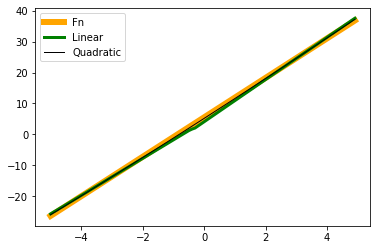

Epoch: 2999 L Loss: 0.3953903019428253 Q Loss: 0.038117971271276474


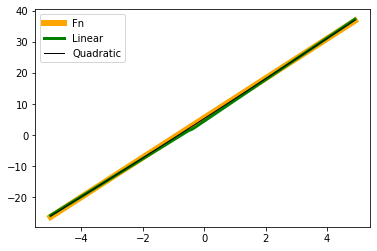

Epoch: 3499 L Loss: 0.2155321091413498 Q Loss: 0.012710953131318092


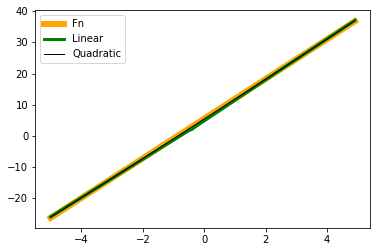

Epoch: 3999 L Loss: 0.11566242575645447 Q Loss: 0.004259975161403418


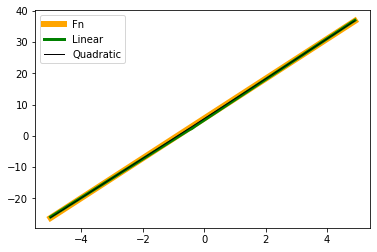

Epoch: 4499 L Loss: 0.059087153524160385 Q Loss: 0.0014289345126599073


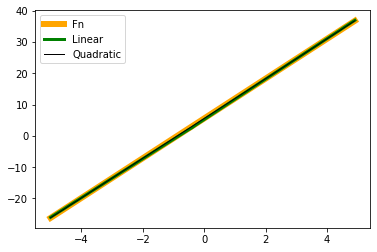

Epoch: 4999 L Loss: 0.03112577088177204 Q Loss: 0.0005029065068811178


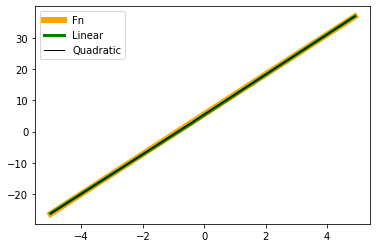

Epoch: 5499 L Loss: 0.016221333295106888 Q Loss: 0.00018995514255948365


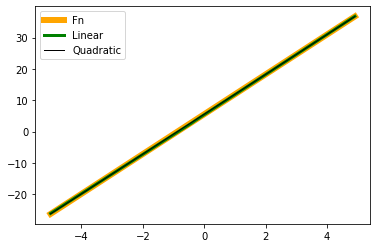

Epoch: 5999 L Loss: 0.008401102386415005 Q Loss: 0.00010113305324921384


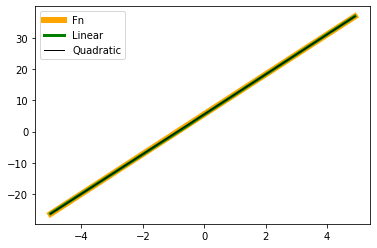

Epoch: 6499 L Loss: 0.004568045027554035 Q Loss: 6.024772301316261e-05


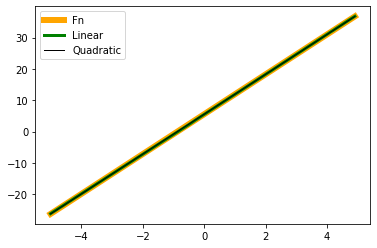

Epoch: 6999 L Loss: 0.002622105646878481 Q Loss: 5.810779475723393e-05


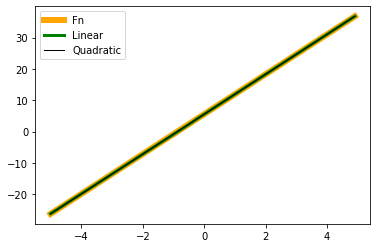

Epoch: 7499 L Loss: 0.0015267772832885385 Q Loss: 3.563445352483541e-05


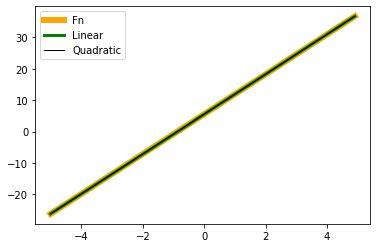

Epoch: 7999 L Loss: 0.0009816869860514998 Q Loss: 3.409187775105238e-05


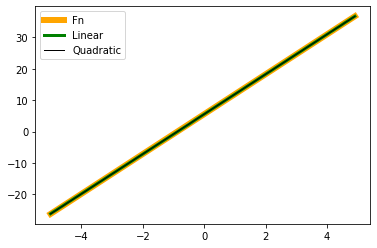

Epoch: 8499 L Loss: 0.0006601329077966511 Q Loss: 3.436707629589364e-05


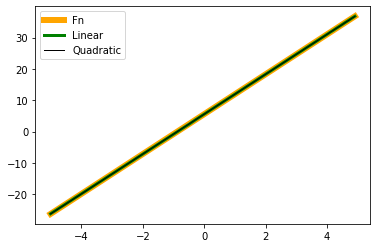

Epoch: 8999 L Loss: 0.0004890030832029879 Q Loss: 3.5273034882266074e-05


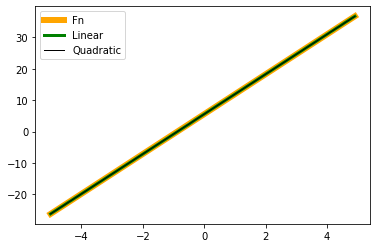

Epoch: 9499 L Loss: 0.0003634131862781942 Q Loss: 3.350855695316568e-05


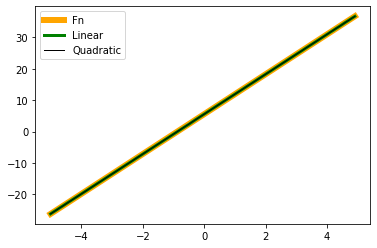

Epoch: 9999 L Loss: 0.0002773609885480255 Q Loss: 3.449818541412242e-05


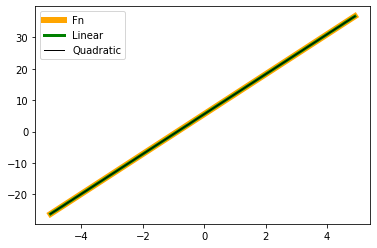

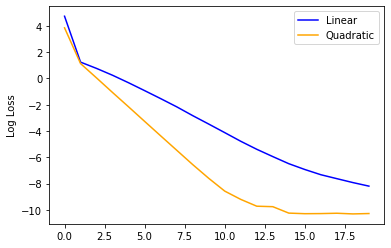

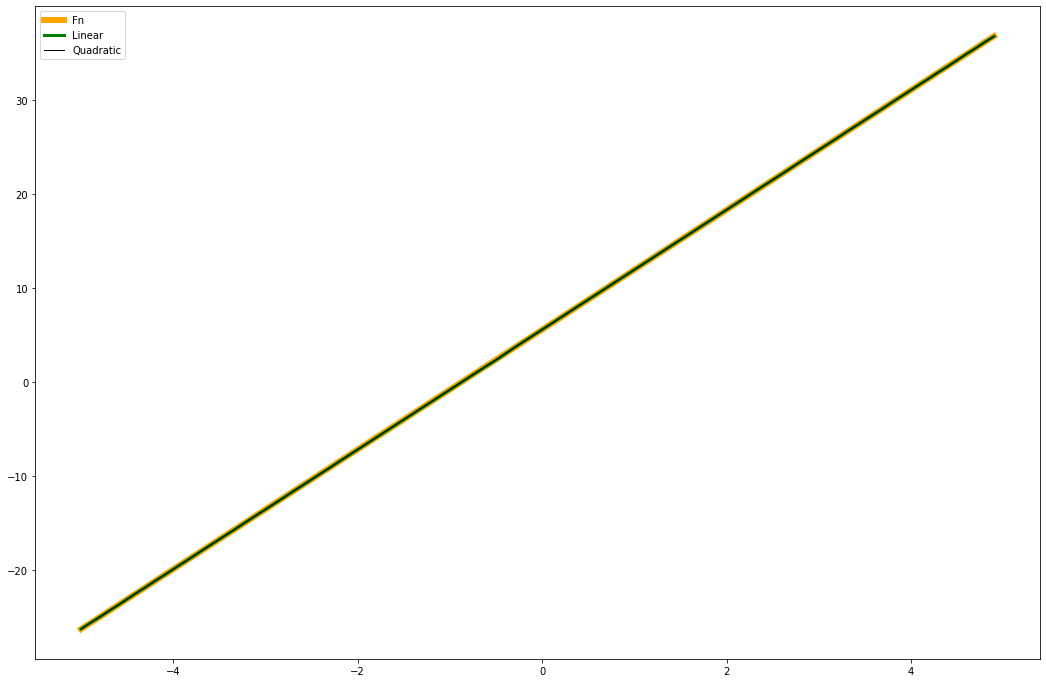

In [10]:
runExperiment(exps[1])

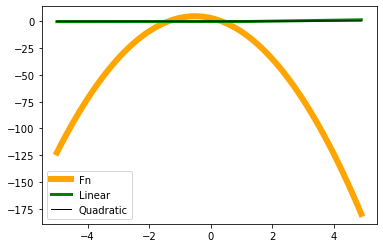

Epoch: 499 L Loss: 907.6461181640625 Q Loss: 676.711181640625


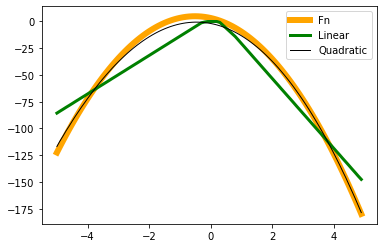

Epoch: 999 L Loss: 187.7664337158203 Q Loss: 10.00705337524414


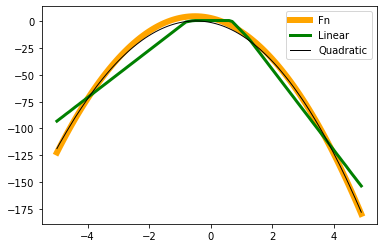

Epoch: 1499 L Loss: 99.11910247802734 Q Loss: 6.616282939910889


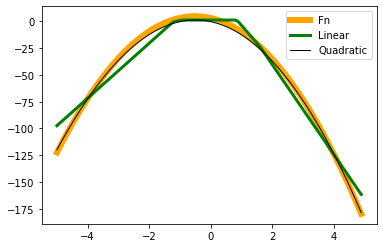

Epoch: 1999 L Loss: 56.060386657714844 Q Loss: 4.41405725479126


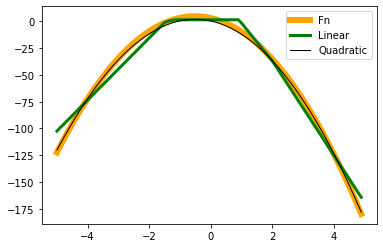

Epoch: 2499 L Loss: 38.69322967529297 Q Loss: 2.806988000869751


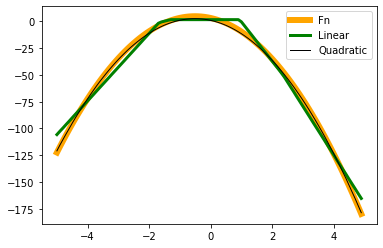

Epoch: 2999 L Loss: 29.516979217529297 Q Loss: 1.7095673084259033


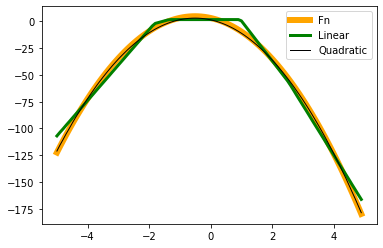

Epoch: 3499 L Loss: 24.926977157592773 Q Loss: 1.0178085565567017


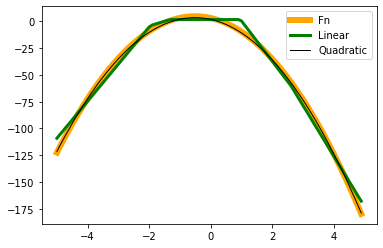

Epoch: 3999 L Loss: 21.473915100097656 Q Loss: 0.5709911584854126


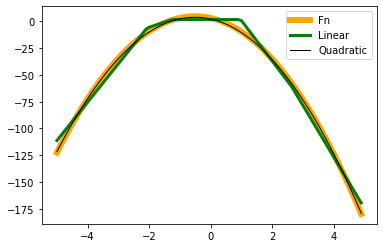

Epoch: 4499 L Loss: 19.331329345703125 Q Loss: 0.3144981861114502


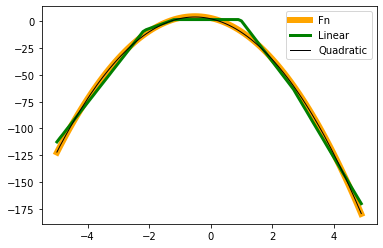

Epoch: 4999 L Loss: 17.302112579345703 Q Loss: 0.1623847782611847


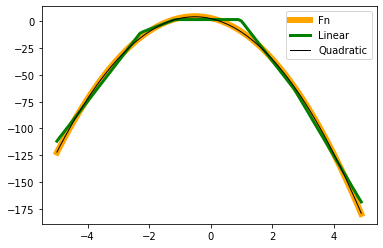

Epoch: 5499 L Loss: 16.18406867980957 Q Loss: 0.08237381279468536


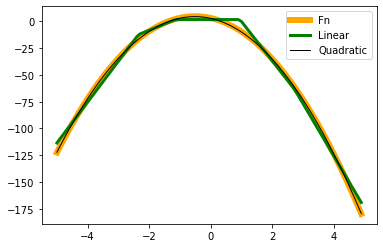

Epoch: 5999 L Loss: 14.991503715515137 Q Loss: 0.04421870410442352


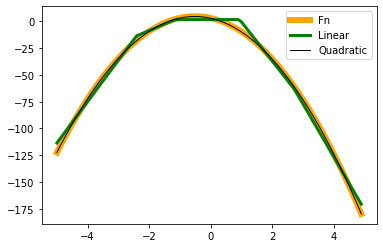

Epoch: 6499 L Loss: 14.156416893005371 Q Loss: 0.02095934934914112


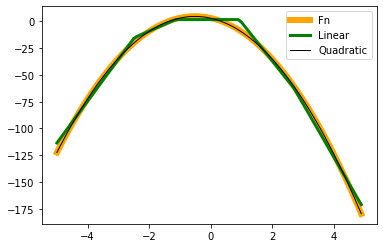

Epoch: 6999 L Loss: 13.193737030029297 Q Loss: 0.012880342081189156


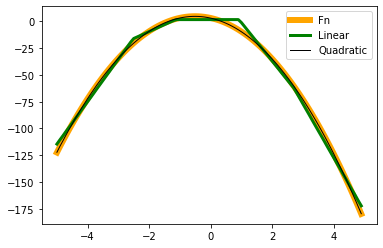

Epoch: 7499 L Loss: 12.344175338745117 Q Loss: 0.009188505820930004


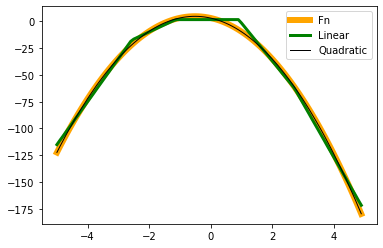

Epoch: 7999 L Loss: 11.423379898071289 Q Loss: 0.006537741515785456


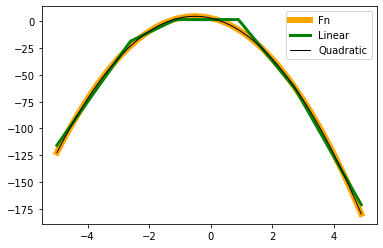

Epoch: 8499 L Loss: 10.656319618225098 Q Loss: 0.005412854254245758


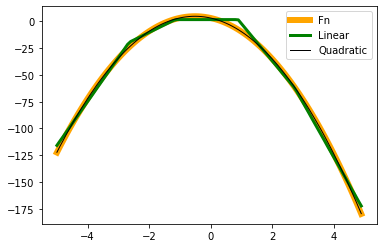

Epoch: 8999 L Loss: 9.99229621887207 Q Loss: 0.004310602322220802


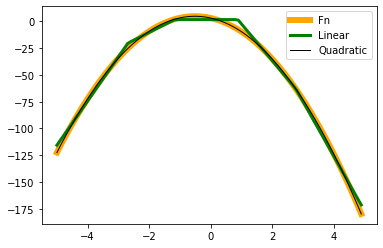

Epoch: 9499 L Loss: 9.353821754455566 Q Loss: 0.003998772706836462


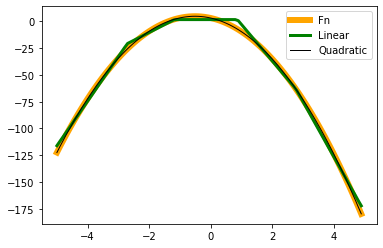

Epoch: 9999 L Loss: 9.141697883605957 Q Loss: 0.003302440047264099


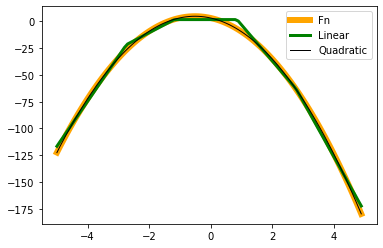

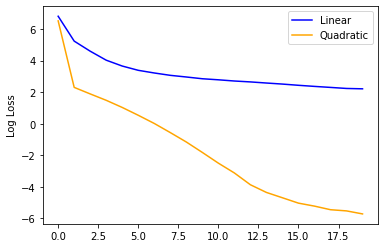

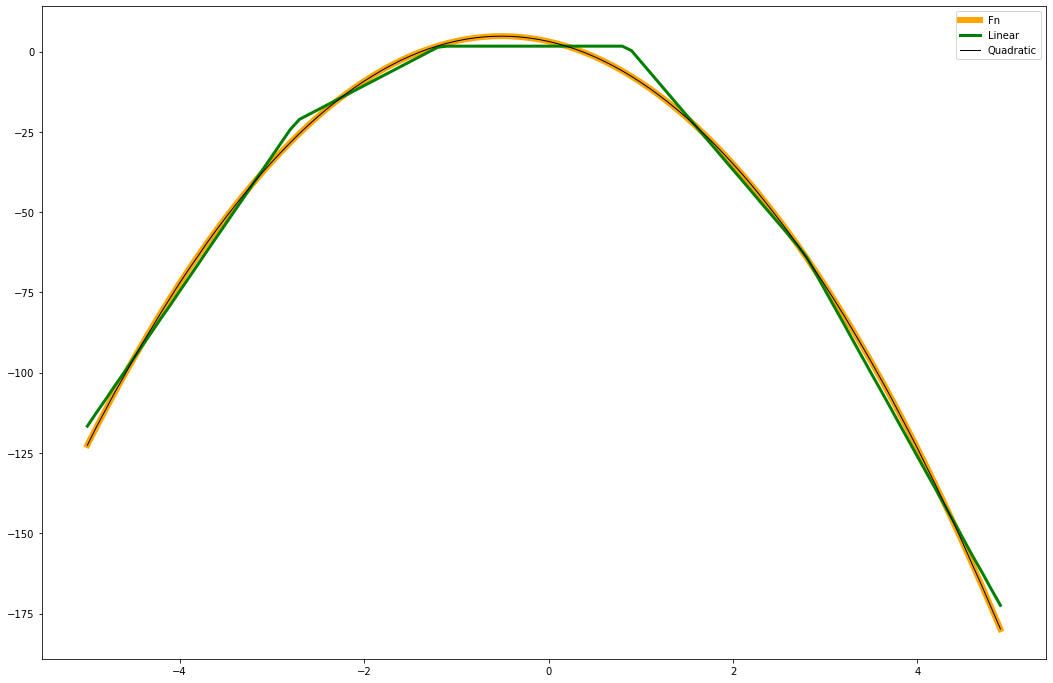

In [11]:
runExperiment(exps[2])

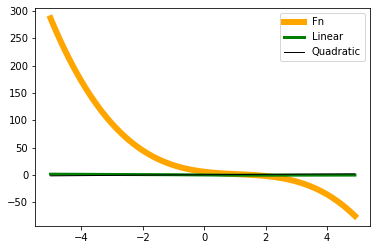

Epoch: 499 L Loss: 1293.40087890625 Q Loss: 1159.36376953125


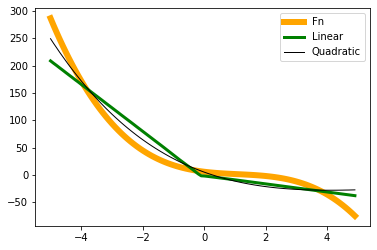

Epoch: 999 L Loss: 431.5574645996094 Q Loss: 235.6371307373047


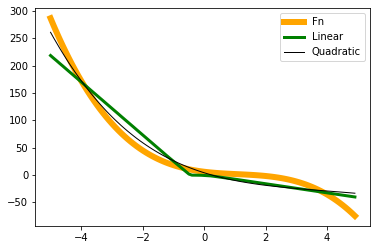

Epoch: 1499 L Loss: 334.9065246582031 Q Loss: 146.72445678710938


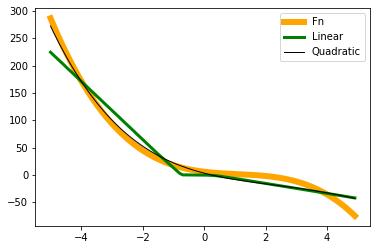

Epoch: 1999 L Loss: 250.54586791992188 Q Loss: 66.35540771484375


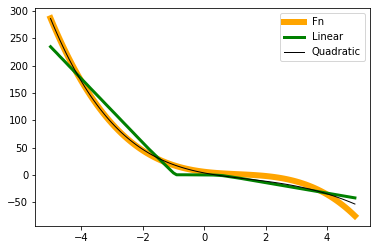

Epoch: 2499 L Loss: 208.42953491210938 Q Loss: 24.678203582763672


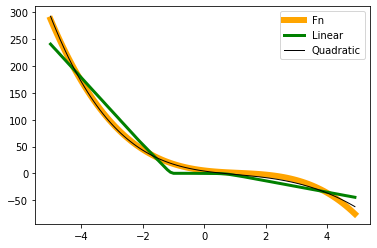

Epoch: 2999 L Loss: 176.72915649414062 Q Loss: 11.766767501831055


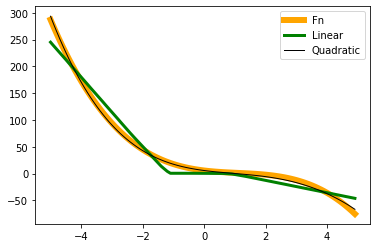

Epoch: 3499 L Loss: 157.77999877929688 Q Loss: 7.2645111083984375


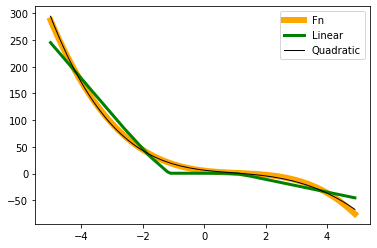

Epoch: 3999 L Loss: 136.77503967285156 Q Loss: 5.350888252258301


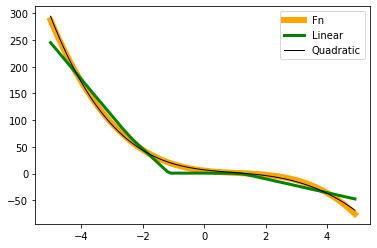

Epoch: 4499 L Loss: 122.15866088867188 Q Loss: 4.469058513641357


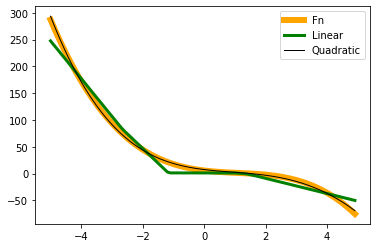

Epoch: 4999 L Loss: 109.33447265625 Q Loss: 3.891796588897705


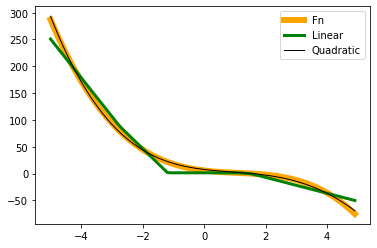

Epoch: 5499 L Loss: 100.93632507324219 Q Loss: 3.5690040588378906


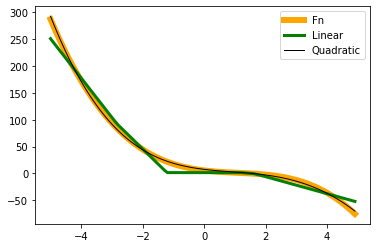

Epoch: 5999 L Loss: 93.39402770996094 Q Loss: 3.2740728855133057


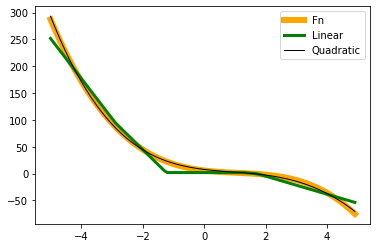

Epoch: 6499 L Loss: 89.07439422607422 Q Loss: 3.1159019470214844


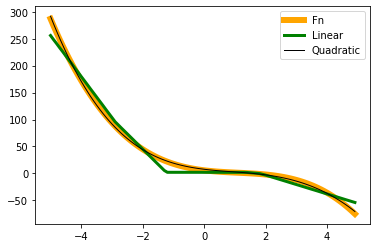

Epoch: 6999 L Loss: 82.56938171386719 Q Loss: 2.8370347023010254


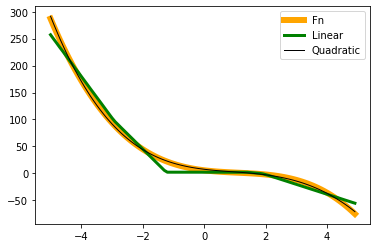

Epoch: 7499 L Loss: 75.93794250488281 Q Loss: 2.6170220375061035


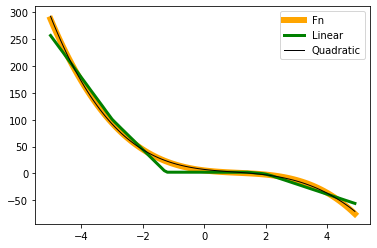

Epoch: 7999 L Loss: 69.94425201416016 Q Loss: 2.4212961196899414


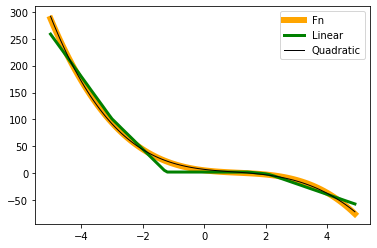

Epoch: 8499 L Loss: 66.97557830810547 Q Loss: 2.295292377471924


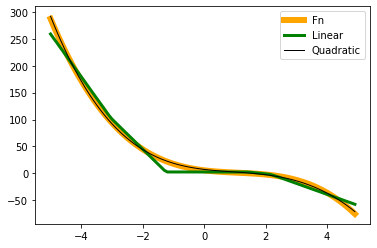

Epoch: 8999 L Loss: 62.669883728027344 Q Loss: 2.149040937423706


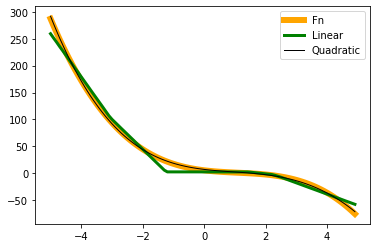

Epoch: 9499 L Loss: 59.18056869506836 Q Loss: 1.9978643655776978


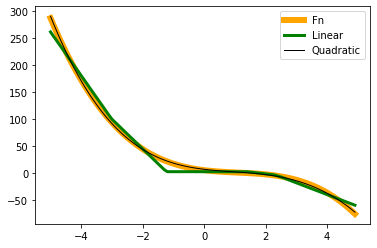

Epoch: 9999 L Loss: 56.201107025146484 Q Loss: 1.8842259645462036


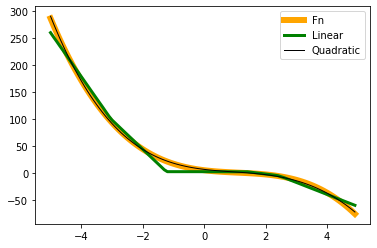

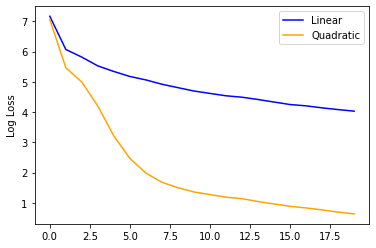

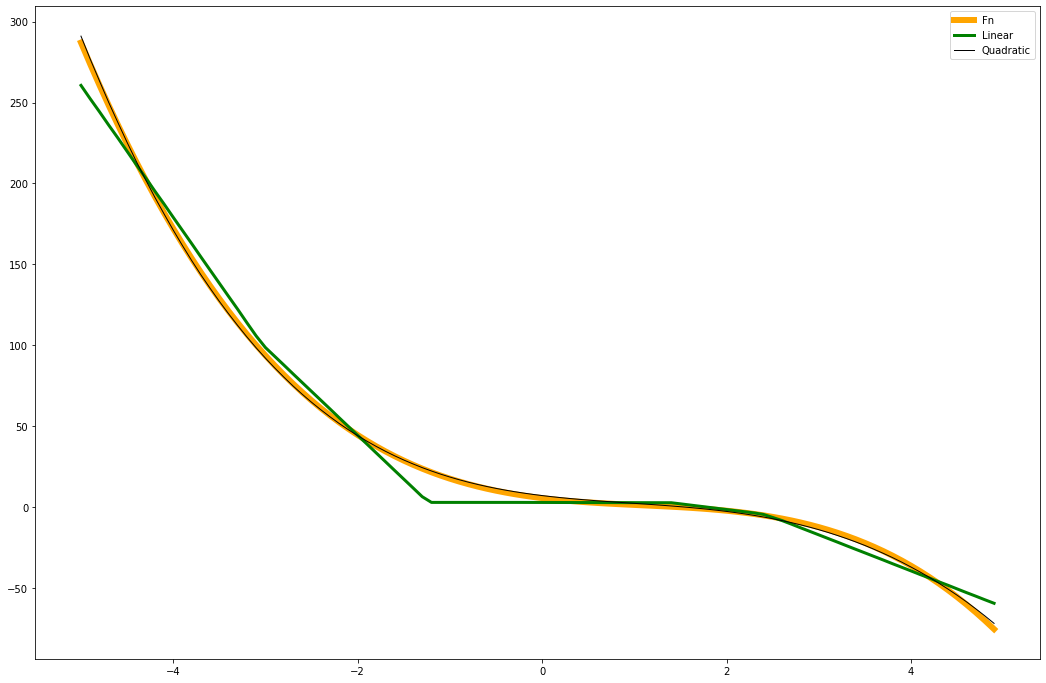

In [12]:
runExperiment(exps[3])

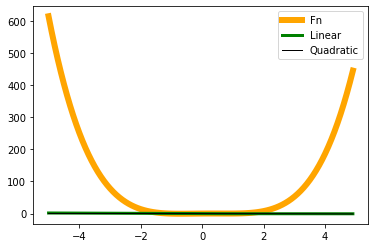

Epoch: 499 L Loss: 9084.533203125 Q Loss: 7454.81103515625


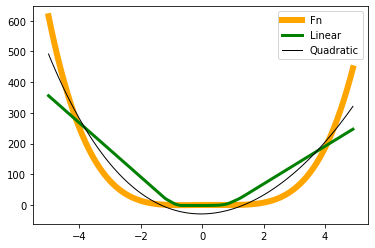

Epoch: 999 L Loss: 3915.1689453125 Q Loss: 1426.2110595703125


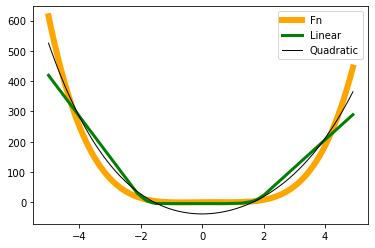

Epoch: 1499 L Loss: 1936.60693359375 Q Loss: 748.9559326171875


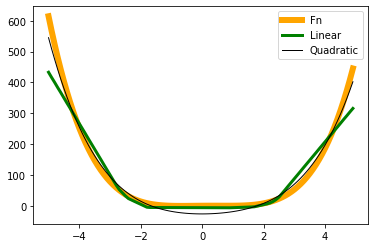

Epoch: 1999 L Loss: 1082.589599609375 Q Loss: 160.70863342285156


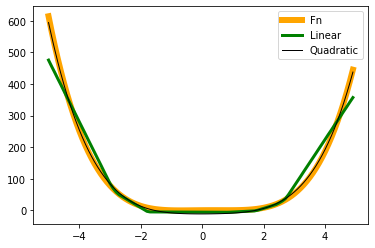

Epoch: 2499 L Loss: 679.0640258789062 Q Loss: 19.573183059692383


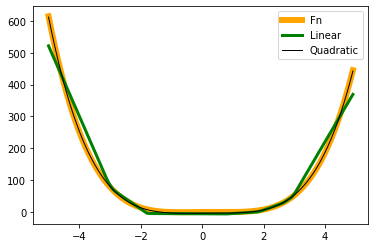

Epoch: 2999 L Loss: 445.7381896972656 Q Loss: 1.7211676836013794


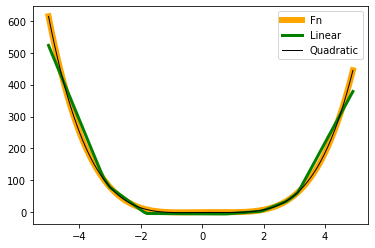

Epoch: 3499 L Loss: 336.48944091796875 Q Loss: 0.12819595634937286


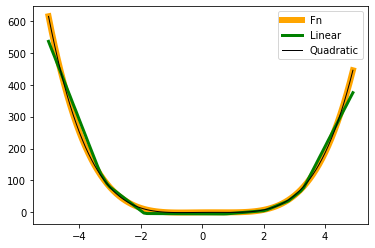

Epoch: 3999 L Loss: 277.44598388671875 Q Loss: 0.01685694046318531


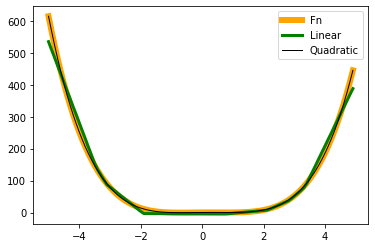

Epoch: 4499 L Loss: 212.81407165527344 Q Loss: 0.009050356224179268


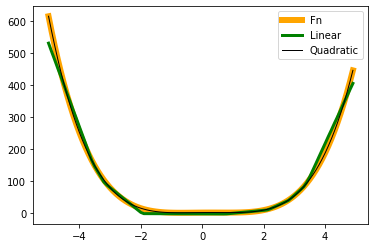

Epoch: 4999 L Loss: 185.81695556640625 Q Loss: 0.006894005462527275


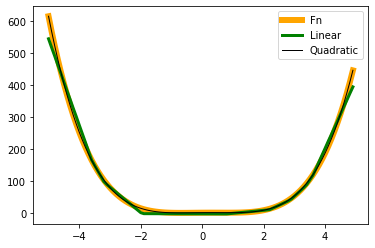

Epoch: 5499 L Loss: 151.84671020507812 Q Loss: 0.009193905629217625


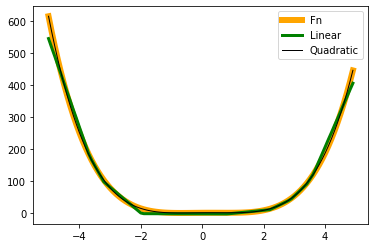

Epoch: 5999 L Loss: 132.16900634765625 Q Loss: 0.010722225531935692


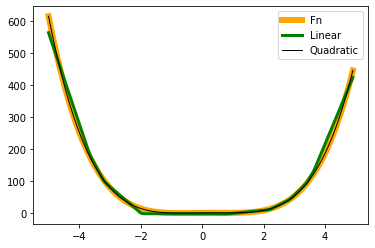

Epoch: 6499 L Loss: 118.81818389892578 Q Loss: 0.00955100730061531


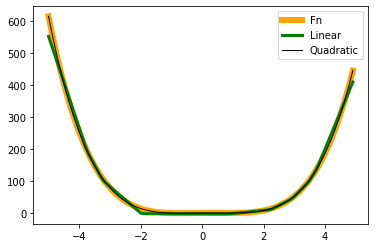

Epoch: 6999 L Loss: 101.78069305419922 Q Loss: 0.008640418760478497


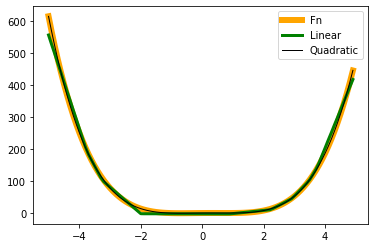

Epoch: 7499 L Loss: 92.17298889160156 Q Loss: 0.010079028084874153


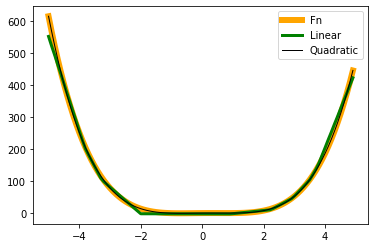

Epoch: 7999 L Loss: 81.2839584350586 Q Loss: 0.010435361415147781


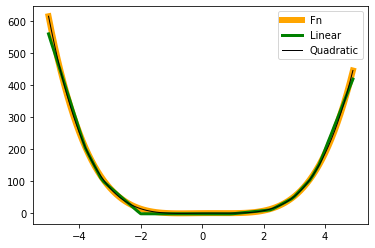

Epoch: 8499 L Loss: 75.60920715332031 Q Loss: 0.010321851819753647


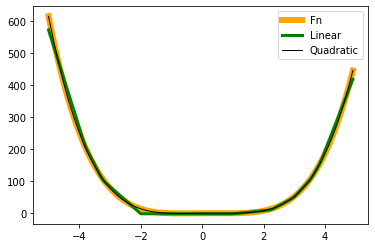

Epoch: 8999 L Loss: 70.06068420410156 Q Loss: 0.010446812957525253


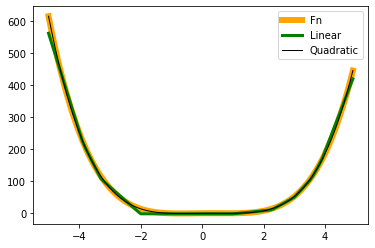

Epoch: 9499 L Loss: 63.35535430908203 Q Loss: 0.00949166715145111


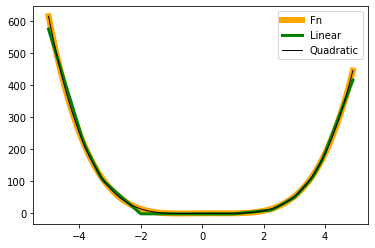

Epoch: 9999 L Loss: 60.72819519042969 Q Loss: 0.010029308497905731


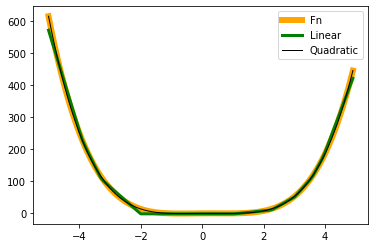

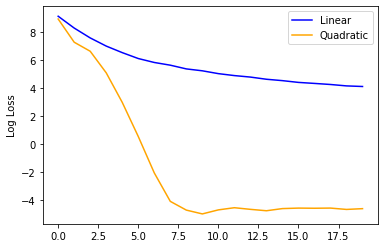

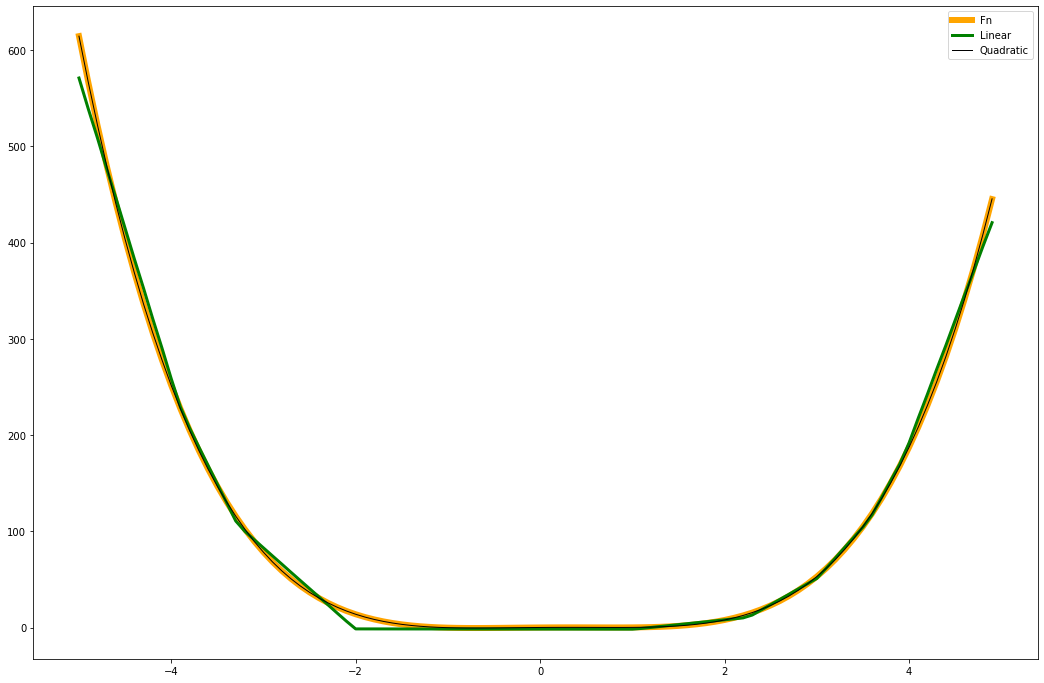

In [13]:
runExperiment(exps[4])